In [1]:
versioninfo()

Julia Version 1.8.2
Commit 36034abf260 (2022-09-29 15:21 UTC)
Platform Info:
  OS: macOS (arm64-apple-darwin21.3.0)
  CPU: 10 × Apple M1 Pro
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, apple-m1)
  Threads: 1 on 8 virtual cores


In [2]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

In [3]:
# load packages
using BenchmarkTools, CSV, DataFrames, Distributions, DynamicHMC, DynamicHMC.Diagnostics, 
    LinearAlgebra, LogDensityProblems, MCMCChains, 
    Parameters, Profile, ProximalOperators,
    Random, Revise, Roots, SparseArrays, Statistics, StatsPlots, StatsFuns, RCall
import ProximalOperators: prox, prox!
gr(size=(1600, 1200))

Plots.GRBackend()

## Helper functions

In [4]:
"""
    vech!(v::AbstractVector, A::AbstractVecOrMat)
Overwrite vector `v` by the entries from lower triangular part of `A`. 
"""
function vech!(v::AbstractVector, A::AbstractVecOrMat)
    m, n = size(A, 1), size(A, 2)
    idx = 1
    @inbounds for j in 1:n, i in j:m
        v[idx] = A[i, j]
        idx += 1
    end
    v
end

"""
    vech(A::AbstractVecOrMat) -> AbstractVector
Return the entries from lower triangular part of `A` as a vector.
"""
function vech(A::AbstractVecOrMat)
    m, n = size(A, 1), size(A, 2)
    vech!(similar(A, n * m - (n * (n - 1)) >> 1), A)
end

"""
    getB(x, p)
Calculate B from B1 and B2.

# Arguments 
- `x`: a n-by-(q*k + k*r) matrix containing the HMC samples for B1 and B2
- `qrk`: a tuple with values q, r, k

# Values
- `Bvec`: a matrix of dimension n-by-(q*r) containing the vectorized B
"""
function getB(x::AbstractMatrix{T}, qrk::Tuple) where T <: Real
    n = size(x, 1)
    q,r,k = qrk
    B  = zeros(q, r)
    B1 = zeros(q, k)
    B2 = zeros(k, r)
    Bvec = zeros(n, q*r)
    for i in 1:n
        copyto!(B1, x[i, 1:q*k])
        copyto!(B2, x[i, q*k+1:end])
        mul!(B, B1, B2)
        @views vech!(Bvec[i, :], B)
    end
    return Bvec
end

"""
    get_ci(x)
Get 95% credible intervals for each column of x. 

# Arguments 
- `x`: an n-by-p matrix

# Values
- `cis`: a p-by-2 matrix of credible intervals for the columns of x
"""
function get_ci(x::AbstractMatrix{T}) where T <: Real
    m = size(x, 2)
    cis = zeros(m, 2)
    for i in 1:m
        cis[i, :] = quantile(x[:,i], [0.025, 0.975])
    end
    return cis
end

get_ci

$$
\newcommand{\logdet}{\operatorname{logdet}}
\newcommand{\vec}{\operatorname{vec}}
\newcommand{\vech}{\operatorname{vech}}
\newcommand{\tr}{\operatorname{tr}}
\newcommand{\prox}{\operatorname{prox}}
\newcommand{\logit}{\operatorname{logit}}
\newcommand{\rank}{\operatorname{rank}}
\newcommand{\Sig}{\operatorname{Sig}}
\newcommand{\diag}{\operatorname{diag}}
\newcommand{\Xbf}{{\mathbf X}}
\newcommand{\Zbf}{{\mathbf Z}}
\newcommand{\Bbf}{{\mathbf B}}
\newcommand{\Thetabf}{\mathbf{\Theta}}
$$



## Proximal MCMC for sparse low rank matrix Regression

Projection onto the set of rank k matrices.

In [5]:
function rank_projection!(Xlr::AbstractMatrix{T}, X::AbstractMatrix{T}, k::Int64) where T <: Real
    Xsvd = svd(X)
    Xsvd.S[k+1:end] .= 0
    copyto!(Xlr, Xsvd.U * Diagonal(Xsvd.S) * Xsvd.Vt)
end

rank_projection! (generic function with 1 method)

Projection onto L1 norm epigraph.

In [6]:
"""
    ϕ(x::Vector, λ)

Return the value `sum(abs, Sλ(x[1:end-1])) - λ - x[end]`.
"""
function ϕ(x::AbstractVector{T}, λ::T) where T <: Real
    out = zero(T)
    @inbounds for i in 1:(length(x) - 1)
        δi = abs(x[i]) - λ
        out += δi > 0 ? abs(δi) : zero(T)
    end
    out -= λ + x[end]
    out
end

ϕ

In [7]:
struct NormL1Epigraph end

is_convex(f::NormL1Epigraph) = true
is_set(f::NormL1Epigraph) = true

function prox!(
        y :: AbstractVector{T}, 
        f :: NormL1Epigraph, 
        x :: AbstractVector{T}, 
        γ :: T = T(1.0)
    ) where T <: Real
    if isinf(x[end]) || sum(abs, x) ≤ x[end] + abs(x[end])
        copyto!(y, x)
        return zero(T)
    end
    @views λ₀ = find_zero(λ -> ϕ(x, λ), (0, maximum(abs, x[1:end-1])), Bisection())
    for i in 1:(length(y) - 1)
        δi   = abs(x[i]) - λ₀
        y[i] = δi > 0 ? copysign(δi, x[i]) : zero(T) 
    end
    y[end] = x[end] + λ₀
    zero(T)
end

prox(f::NormL1Epigraph, x::AbstractVector{T}, γ::T = T(1.0)) where T<:Real = 
    prox!(similar(x), f, x, γ)

prox (generic function with 4 methods)

In [8]:
# RMR = Regularized Matrix Regression
struct SLMRProblem{T <: Real}
    y        :: Vector{T} # response
    Z        :: Matrix{T} # Vector covariates
    X        :: AbstractArray{T} # # Matrix covariates
    λ        :: T         # Moreau-Yosida envelope parameter
    σ²prior  :: Tuple{T, T}
    αprior   :: Tuple{T, T} # IG(r, s) prior for α  
    γ        :: Vector{T}
    B        :: Matrix{T}
    Bproj    :: Matrix{T}
    Btemp    :: Matrix{T}
    k        :: Int64 # user-specified rank of B
    Bα       :: Vector{T}
    Bα_prox  :: Vector{T}
end

# constructor
function SLMRProblem(y::Vector{T}, Z::Matrix{T}, X::AbstractArray{T}, 
        λ::T, σ²prior::Tuple{T, T}, αprior::Tuple{T, T}, k::Int64) where T <: Real
    p         = size(Z, 2)
    q, r      = size(X[:, :, 1])
    γ         = Vector{T}(undef, p)
    B         = Matrix{T}(undef, q, r)
    Bproj     = Matrix{T}(undef, q, r)
    Btemp     = Matrix{T}(undef, q, r)
    Bα        = Vector{T}(undef, q*r + 1)
    Bα_prox   = similar(Bα)
    SLMRProblem{T}(y, Z, X, λ, σ²prior, αprior, γ, B, Bproj, Btemp, k, Bα, Bα_prox)
end

SLMRProblem

In [9]:
(problem::SLMRProblem)(θ) = LogDensityProblems.logdensity(problem, θ)

LogDensityProblems.capabilities(::Type{<:SLMRProblem}) =
    LogDensityProblems.LogDensityOrder{1}()

LogDensityProblems.dimension(problem::SLMRProblem) = length(problem.γ) + prod(size(problem.B)) + 2

In [10]:
function LogDensityProblems.logdensity(problem::SLMRProblem, paras)
    @unpack y, Z, X, λ, σ²prior, αprior, γ, B, Bproj, Btemp, k, Bα, Bα_prox = problem
    rσ², sσ²  = σ²prior
    rα , sα   = αprior  
    p = length(γ)
    q, r = size(B)
    n = length(y)
    
    copyto!(γ,  1, paras, 1,   p)
    copyto!(B,  1, paras, p+1, q*r)
    logσ² = paras[end-1]
    logα  = paras[end]
    α     = exp(logα)
    σ²    = exp(logσ²)
    
    # log-likelihood + log(prior), with constant terms dropped
    c1 = 2 * rσ²
    c2 = -(n/2 + sσ²)
    logl =  c2 * logσ² - sα * logα - rα / α 
    @inbounds for i in 1:n
        @views c1 += (y[i] - dot(γ, Z[i, :]) - dot(B, X[:, :, i]))^2
    end
    c1   /= (2 * σ²)
    logl -= c1

    # rank projection
    rank_projection!(Bproj, B, k)
    Btemp .= B .- Bproj
    logl -= abs2(norm(Btemp)) / (2λ)
    
    # epigraph projection
    copyto!(Bα, B)
    Bα[end] = α
    prox!(Bα_prox, NormL1Epigraph(), Bα)
    Bα_prox .= Bα .- Bα_prox
    logl -= abs2(norm(Bα_prox)) / (2λ)
    logl
end

In [11]:
function LogDensityProblems.logdensity_and_gradient(problem::SLMRProblem{T}, paras) where T <: Real
    @unpack y, Z, X, λ, σ²prior, αprior, γ, B, Bproj, Btemp, k, Bα, Bα_prox = problem
    rσ², sσ²  = σ²prior
    rα , sα   = αprior  
    p = length(γ)
    q, r = size(B)
    n = length(y)
    invλ = inv(λ)
    
    ∇  = fill(T(0), p + q*r + 2)
    ∇γ = fill(T(0), p)
    ∇B = fill(T(0), q, r)
    
    copyto!(γ,  1, paras, 1, p)
    copyto!(B,  1, paras, p+1, q*r)
    logσ² = paras[end-1]
    logα  = paras[end]
    α     = exp(logα)
    σ²    = exp(logσ²)

    if α == Inf
        logl = -Inf
        ∇ = zeros(p + q*r + 2)
        return logl, ∇
    end
        
    # log-likelihood + log(prior), with constant terms dropped
    c1 = 2 * rσ²
    c2 = -(n/2 + sσ²)
    logl =  c2 * logσ² - sα * logα - rα / α 
    @inbounds for i in 1:n
        @views ctemp = y[i] - dot(γ, Z[i, :]) - dot(B, X[:, :, i])
        c1   += ctemp^2
        @views ∇γ  .+= ctemp * Z[i, :]
        @views ∇B  .+= ctemp * X[:, :, i]
    end
    c1     /= (2 * σ²)
    logl   -= c1
    ∇γ    ./= σ²
    ∇B    ./= σ²
    
    # rank projection
    rank_projection!(Bproj, B, k)
    Btemp .= B .- Bproj
    logl  -= abs2(norm(Btemp)) / (2λ)
    ∇B   .-= invλ * Btemp
    
    # epigraph projection
    copyto!(Bα, B)
    Bα[end] = α
    prox!(Bα_prox, NormL1Epigraph(), Bα)
    Bα_prox .= Bα .- Bα_prox
    logl -= abs2(norm(Bα_prox)) / (2λ)
    copyto!(Btemp, 1, Bα_prox, 1, q*r)
    ∇B   .-= invλ * Btemp
    
    copyto!(∇, ∇γ)
    copyto!(∇, p+1, ∇B, 1, q*r)
    ∇[end - 1] = c2 + c1
    ∇[end]     = rα / α - sα - invλ * α * Bα_prox[end]
    logl, ∇
end

# Detecting the cross shaped signal

In [12]:
using Images, FileIO

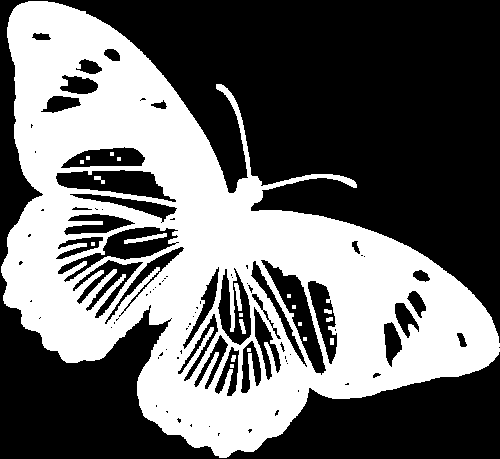

In [13]:
Bimage = Gray.(load("../data/butterfly.gif"))

In [14]:
q = 25
r = 25

25

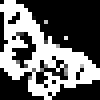

In [15]:
Bimage_resized = imresize(Bimage, (q, r))

In [16]:
B = zeros(q, r)
for i in 1:q, j in 1:r
    B[q-i+1, j] = Float64(Bimage_resized[i, j])
end

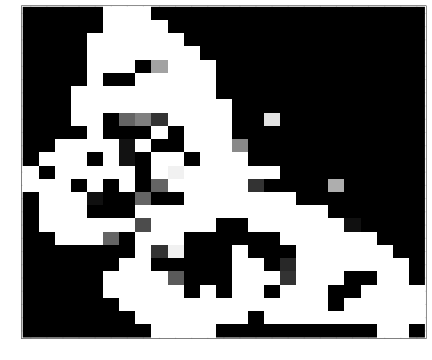

RObject{VecSxp}


In [17]:
@rput B
R"""
library(reshape2)
library(ggplot2)
library(dplyr)
B %>% melt() %>%
  ggplot() + 
  geom_raster(aes(x = factor(Var1), y = factor(Var2), fill = value)) + 
  scale_fill_gradient(low = "black", high = "white") +
  theme_bw() + 
  labs(x = "", y = "") + 
  theme(legend.position = "none", axis.text.x=element_blank(), 
      axis.ticks.x=element_blank(), 
      axis.text.y=element_blank(), 
      axis.ticks.y=element_blank())
#ggsave("../plots/SLMR-TrueSignal.eps", dpi = 300, width = 4, height = 4)
"""

In [18]:
Random.seed!(123)
n = 2000 
p = 2
Z = randn(n, p)
X = randn(q, r, n)
γ = ones(p)
σ = 1;

In [19]:
y = σ * randn(n)
for i in 1:n
    @views y[i] += dot(Z[i, :], γ) + dot(B, X[:, :, i])
end

In [20]:
# initialize B using LS without regularization
# The design matrix is [Z_i vec(X_i)] 
# The coefficient is [γ vec(B)]
Xnew = zeros(n, p+q*r)
for i in 1:n
    Xnew[i, :] = vcat(Z[i, :], vec(X[:,:,i]))
end
γB = Xnew \ y
B₀ = similar(X[:,:,1])
copyto!(B₀, γB[3:end]);

In [21]:
k = 20
λ = 0.001 
σ²prior = (0.01, 0.01)
αprior  = (sum(svdvals(B₀)), 2.) 
rmr = SLMRProblem(y, Z, X, λ, σ²prior, αprior, k);

In [22]:
γ₀ = zeros(p)
α₀ = 1.0
σ²₀= 1.0
paras = vcat(γ₀, vec(B₀), log(σ²₀), log(α₀));

In [23]:
LogDensityProblems.logdensity(rmr, paras)

-125841.13387071944

In [ ]:
# takes several hours
results = mcmc_with_warmup(Random.GLOBAL_RNG, rmr, 10_000, reporter=ProgressMeterReport(), initialization = (q = paras,));

In [25]:
summarize_tree_statistics(results.tree_statistics)

Hamiltonian Monte Carlo sample of length 10000
  acceptance rate mean: 0.69, 5/25/50/75/95%: 0.29 0.53 0.7 0.89 1.0
  termination: divergence => 0%, max_depth => 0%, turning => 100%
  depth: 0 => 0%, 1 => 0%, 2 => 0%, 3 => 0%, 4 => 0%, 5 => 0%, 6 => 0%, 7 => 0%, 8 => 0%, 9 => 100%

In [26]:
results_matrix = transpose(results.posterior_matrix);

In [ ]:
CSV.write("../results/SLMR-N2000-K20.csv", DataFrame(results_matrix, :auto))

In [ ]:
results_matrix = CSV.read("../results/SLMR-N2000-K20.csv", DataFrame);

In [41]:
p = 2
q = 25
r = 25

25

In [42]:
chn = Chains(
    Matrix(results_matrix),
    ["γ[" .* string.(1:p) .* "]"; "B[" .* string.(1:(q*r)) .* "]"; "σ²"; "α"],
    thin = 10);

In [43]:
result_summary = DataFrame(summarize(chn));
result_quantile = DataFrame(quantile(chn));

In [44]:
B_postmean = zeros(q, r)
copyto!(B_postmean, result_summary[(p+1):(p+q*r), 2]);

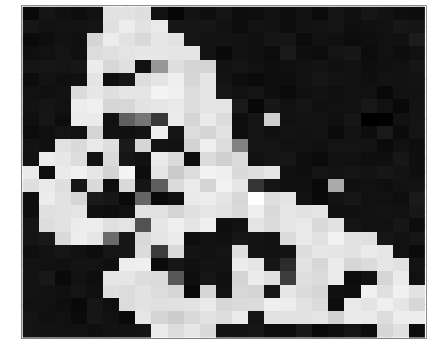

RObject{VecSxp}


In [45]:
@rput B_postmean
R"""
library(reshape2)
library(ggplot2)
library(dplyr)
B_postmean %>% melt() %>%
  ggplot() + 
  geom_raster(aes(x = factor(Var1), y = factor(Var2), fill = value)) + 
  scale_fill_gradient(low = "black", high = "white") +
  theme_bw() + 
  labs(x = "", y = "") + 
  theme(legend.position = "none", axis.text.x=element_blank(), 
      axis.ticks.x=element_blank(), 
      axis.text.y=element_blank(), 
      axis.ticks.y=element_blank())
#ggsave("../plots/SLMR-PostMean-N2000-K20.eps", dpi = 300, width = 4, height = 4)
"""

In [46]:
df = result_quantile[(p+1):(p+q*r), ["parameters", "2.5%", "97.5%"]]
df[:, :truth] = vec(B);

In [47]:
# Calculates coverage
cover = zeros(size(df, 1))
for i in 1:length(cover)
    cover[i] = df[i, 2] ≤ df[i, 4] ≤ df[i, 3] ? 1 : 0
end
sum(cover)/length(cover) 

0.9488

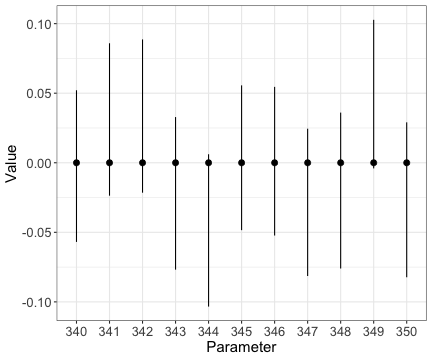

RObject{VecSxp}


In [48]:
# Plot CI for some parameters
@rput df

R"""
library(ggplot2)
colnames(df) <- c("Parameter", "lower", "upper", "truth")
firstidx = 13*25+15
lastidx  = 14*25
df$Variable <- factor(1:nrow(df))
ggplot(df[firstidx:lastidx, ], aes(Variable), dpi = 300) + 
  geom_linerange(aes(ymin = lower, ymax = upper)) + 
  geom_point(aes(x = Variable, y = truth), size = 2.5) + labs(y = "Value", x = "Parameter") + theme_bw() +
  theme(axis.text=element_text(size=13), axis.title=element_text(size=15))
#ggsave("results/FRMR-Gaussian-FixedRank-N2000-CI-1s.png", dpi = 300)
"""

In [49]:
B_se = similar(B)
copyto!(B_se, result_summary[(p+1):(p+q*r), 3]);

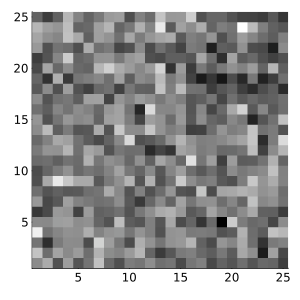

In [50]:
gr(size = (300,300))
heatmap(B_se, c =:greys, dpi = 500, size = (300, 300), legend = :none)
# savefig("../plots/SLMR-PostSE-K20.png")

In [51]:
cov_matrix = cov(Matrix(results_matrix[:, 3:627]))
F = svd(cov_matrix)
v_strongest = F.V[:,1]
slowest = Matrix(results_matrix[:, 3:627]) * v_strongest

10000-element Vector{Float64}:
 0.557689537270334
 0.4965021184504727
 0.49623613024286356
 0.5322534686700864
 0.5822893485525289
 0.6033015448561835
 0.5829291996350374
 0.6290411154190398
 0.6161789650418535
 0.6208214663568464
 0.6268262790155223
 0.5762870999755487
 0.6084332005008415
 ⋮
 0.547033792483083
 0.5469774207317786
 0.5236547551841961
 0.5522265530697029
 0.5121738400699656
 0.5429683673093352
 0.5556955932785049
 0.5553240542325648
 0.5339888754464928
 0.5844841326646041
 0.5889541695567283
 0.5440875085973746

In [52]:
chn_slowest = MCMCChains.Chains(slowest, ["Bslowest"], thin = 1);

In [53]:
ess_slowest = ess_rhat(chn_slowest)

ESS
  parameters         ess      rhat 
      Symbol     Float64   Float64 

    Bslowest   3217.5404    0.9999
